In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix ,  accuracy_score , classification_report
from collections import Counter
import PySimpleGUI as sg
import warnings 
from warnings import filterwarnings
filterwarnings("ignore")

# Data Collection

In [2]:
con = sqlite3.connect("E:/Datascience/password_prediction/password_Data.sqlite")

In [3]:
data = pd.read_sql_query("SELECT * FROM Users",con)

In [4]:
data.shape

(100000, 3)

# Data Cleaning

In [5]:
data.head()

index                 password  strength
0      0                zxe870819         1
1      1             xw46454nr23l         1
2      2                soporte13         1
3      3  accounts6000webhost.com         2
4      4                 c443balg         1

In [6]:
data.columns

Index(['index', 'password', 'strength'], dtype='object')

In [7]:
data.drop(["index"],axis=1,inplace=True)

In [8]:
data.head(4)

password  strength
0                zxe870819         1
1             xw46454nr23l         1
2                soporte13         1
3  accounts6000webhost.com         2

In [9]:
data.duplicated().sum()

0

In [10]:
data.isnull().any()

password    False
strength    False
dtype: bool

In [11]:
data["strength"].unique()

array([1, 2, 0], dtype=int64)

# Data Analysis
## Performing Semantic Analysis !
- How many password textual actually holds only numeric characters?
- How many password textual actually holds only Upper-case character?
- How many password textual actually holds only alphabet?
- How many password textual actually holds alpha-numeric character?
- How many password textual actually holds title-case character?
- How many password textual actually holds some special special character?

In [12]:
data["password"][0]
type

type

In [13]:
data["password"].str.isnumeric()

0        False
1        False
2        False
3        False
4        False
         ...  
99995    False
99996    False
99997    False
99998    False
99999    False
Name: password, Length: 100000, dtype: bool

In [14]:
data[data["password"].str.isnumeric()].shape

(26, 2)

- only 26 people have set their password as only number

In [15]:
data[data["password"].str.isupper()].shape
# around 1500 users have their password as only capital letters

(1506, 2)

In [16]:
data[data["password"].str.isalpha()].shape
# around 50 users have their password as alphabet letters only

(50, 2)

In [17]:
data[data["password"].str.isalnum()].shape
# most of the users around 97K have their password as alpha-numeric

(97203, 2)

In [18]:
data[data["password"].str.istitle()].shape
# around 932 users have their password having first alphabet capital

(932, 2)

In [19]:
string.punctuation ## all punctuations defined in "string" package

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [20]:
data.shape[0]

100000

In [21]:
def find_sementics(row):
    for char in row:
        if char in string.punctuation:
            return 1
        else:
            pass

In [22]:
data[data["password"].apply(find_sementics)==1].shape
# 2663 observations have special characters in between them

(2663, 2)

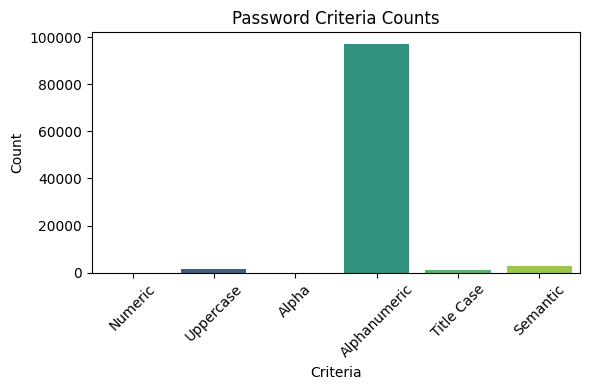

In [23]:
numeric_count = data[data['password'].str.isnumeric()].shape[0]
uppercase_count = data[data['password'].str.isupper()].shape[0]
alpha_count = data[data['password'].str.isalpha()].shape[0]
alnum_count = data[data['password'].str.isalnum()].shape[0]
title_count = data[data['password'].str.istitle()].shape[0]
semantic_count = data[data['password'].apply(find_sementics) == 1].shape[0]

counts = pd.DataFrame({
    'Criteria': ['Numeric', 'Uppercase', 'Alpha', 'Alphanumeric', 'Title Case', 'Semantic'],
    'Count': [numeric_count, uppercase_count, alpha_count, alnum_count, title_count, semantic_count]
})

fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x='Criteria', y='Count', hue='Criteria', data=counts, palette='viridis', legend=False)
plt.title('Password Criteria Counts')
plt.xlabel('Criteria')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Feature Engineering
## Feature on which password depends on:-
- Length of password
- Frequency of Lowercase Characters
- Frequency of Uppercase Characters
- Frequency of Numeric Characters
- Frequency of Special Characters

In [24]:
data["password"][0]

'zxe870819'

In [25]:
len(data["password"][0])


9

In [26]:
data["length"] = data["password"].str.len()

In [27]:
def freq_lowercase(row): # Frequency of Lowercase Characters
    return len([char for char in row if char.islower()])/len(row)
    
data["lowercase_freq"] = np.round(data["password"].apply(freq_lowercase) , 3)

In [28]:
def freq_uppercase(row): # Frequency of Uppercase Characters
    return len([char for char in row if char.isupper()])/len(row)

data["uppercase_freq"] = np.round(data["password"].apply(freq_uppercase) , 3)

In [29]:
def freq_numerical_case(row): # Frequency of Numeric Characters
    return len([char for char in row if char.isdigit()])/len(row)

data["digit_freq"] = np.round(data["password"].apply(freq_numerical_case) , 3)

In [30]:
def freq_special_case(row): # Frequency of Special-case Characters
    special_chars = []
    for char in row:
        if not char.isalpha() and not char.isdigit():
            special_chars.append(char)
    return len(special_chars)

data["special_char_freq"] = np.round(data["password"].apply(freq_special_case),3)
data["special_char_freq"] = data["special_char_freq"]/data["length"] # noromalising "special_char_freq" feature 

In [31]:
data.head(5)

password  strength  length  lowercase_freq  uppercase_freq  \
0                zxe870819         1       9           0.333             0.0   
1             xw46454nr23l         1      12           0.417             0.0   
2                soporte13         1       9           0.778             0.0   
3  accounts6000webhost.com         2      23           0.783             0.0   
4                 c443balg         1       8           0.625             0.0   

   digit_freq  special_char_freq  
0       0.667           0.000000  
1       0.583           0.000000  
2       0.222           0.000000  
3       0.174           0.043478  
4       0.375           0.000000

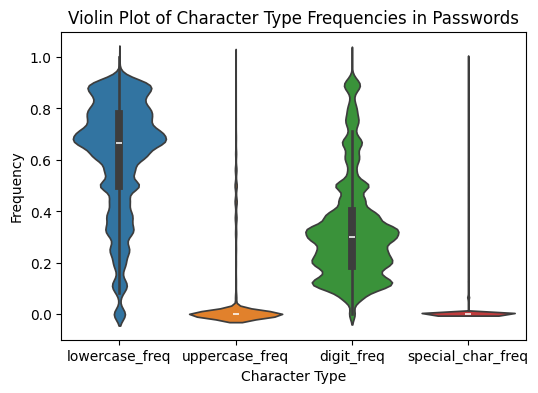

In [32]:
plt.figure(figsize=(6, 4))
sns.violinplot(data=data[['lowercase_freq', 'uppercase_freq', 'digit_freq', 'special_char_freq']])
plt.title('Violin Plot of Character Type Frequencies in Passwords')
plt.xlabel('Character Type')
plt.ylabel('Frequency')
plt.show()

# Descriptive Statistics

In [33]:
data.columns

Index(['password', 'strength', 'length', 'lowercase_freq', 'uppercase_freq',
       'digit_freq', 'special_char_freq'],
      dtype='object')

In [34]:
data[['length','strength']].groupby(['strength']).agg(['min','max','mean','median'])

length                       
            min  max       mean median
strength                              
0             1    7   6.550947    7.0
1             8   13   9.611074    9.0
2            14  220  15.953421   16.0

In [35]:
cols = ['length','lowercase_freq','uppercase_freq','digit_freq','special_char_freq']

for col in cols:
    print(col)
    print(data[[col,'strength']].groupby(['strength']).agg(['min','max','mean','median']))
    print('\n')

# Higher the length, Higher the strength

length
         length                       
            min  max       mean median
strength                              
0             1    7   6.550947    7.0
1             8   13   9.611074    9.0
2            14  220  15.953421   16.0


lowercase_freq
         lowercase_freq                        
                    min    max      mean median
strength                                       
0                   0.0  1.000  0.708050  0.714
1                   0.0  0.923  0.630067  0.667
2                   0.0  0.917  0.424679  0.400


uppercase_freq
         uppercase_freq                        
                    min    max      mean median
strength                                       
0                   0.0  1.000  0.012872  0.000
1                   0.0  0.923  0.007915  0.000
2                   0.0  0.889  0.367633  0.429


digit_freq
         digit_freq                        
                min    max      mean median
strength                                   
0   

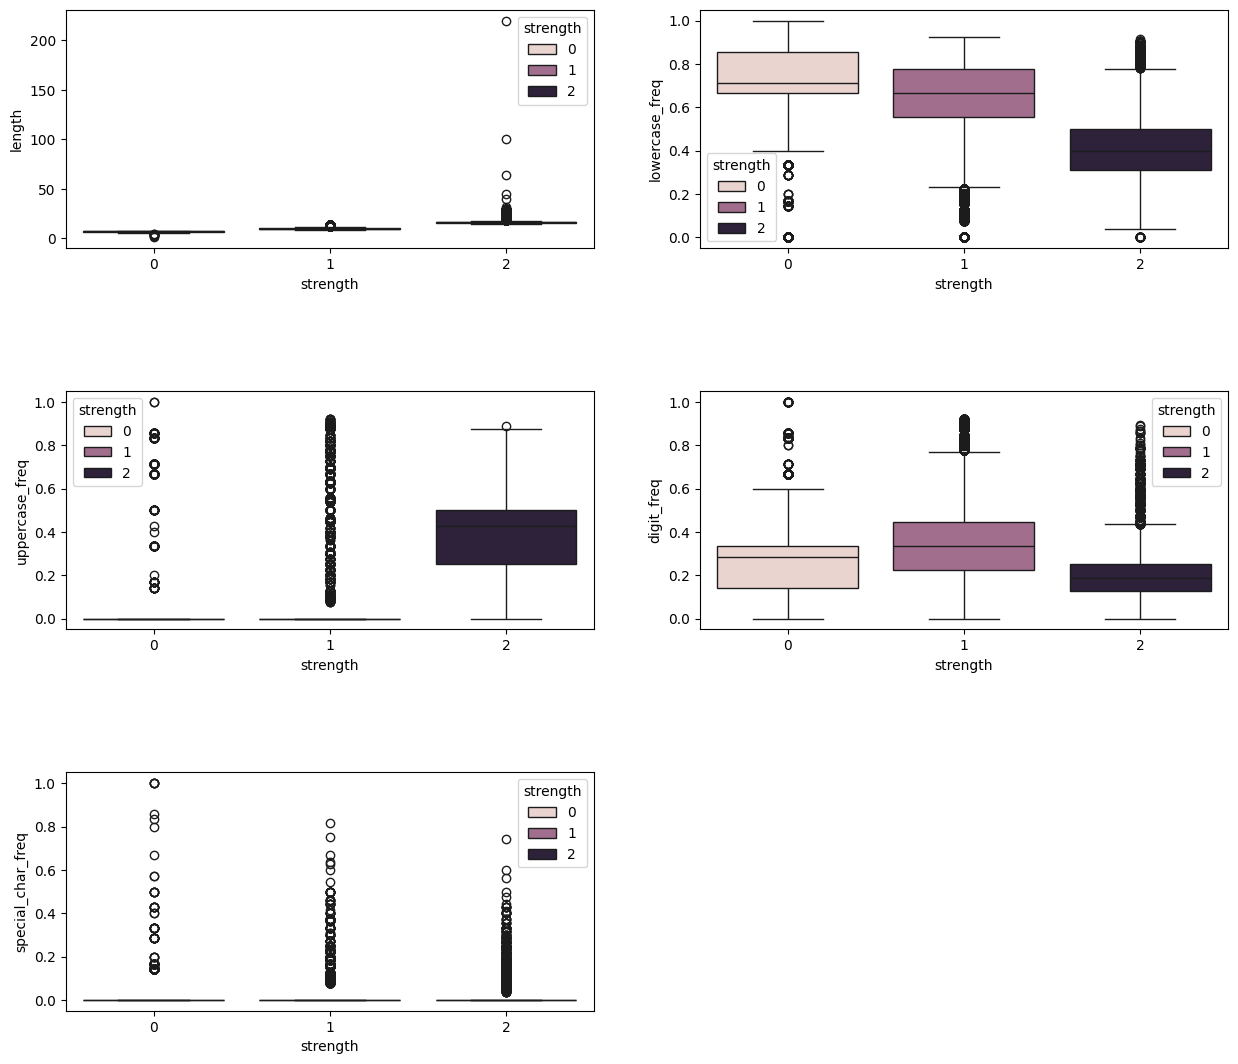

In [36]:
fig, axes = plt.subplots(3, 2, figsize=(15, 13))

axes = axes.flatten()

sns.boxplot(x="strength", y='length', hue="strength", ax=axes[0], data=data)
sns.boxplot(x="strength", y='lowercase_freq', hue="strength", ax=axes[1], data=data)
sns.boxplot(x="strength", y='uppercase_freq', hue="strength", ax=axes[2], data=data)
sns.boxplot(x="strength", y='digit_freq', hue="strength", ax=axes[3], data=data)
sns.boxplot(x="strength", y='special_char_freq', hue="strength", ax=axes[4], data=data)

fig.delaxes(axes[5])

plt.subplots_adjust(hspace=0.6)

plt.show()


'''
Insights :

->> Higher Lowercase frequency is seen in low strength passwords. 
    For higher strength passwords ,  Lowercase frequency can be high too but that is probably effect of length.


->> In digit_freq there is a split of majority poplutation of strength 1 and 2 
    but for 0 and 1 strength , there is overlap so no too much to say there. 
    But we can say a nicely propotioned password is good..
    
    
->> In upper_freq , there is a trend but not as strong as length or lower_freq..
    
    
->> Similar but stronger same trend as above in special_freq.

->> Higher strength passwords have more type breaks.


'''

#  Feature Importance ! ( How to figure out imp. feature )

In [37]:
data.columns

Index(['password', 'strength', 'length', 'lowercase_freq', 'uppercase_freq',
       'digit_freq', 'special_char_freq'],
      dtype='object')

In [38]:
def get_dist(data,feature):
    plt.figure(figsize=(10,8))
    plt.subplot(1,2,1)
    sns.violinplot(x = 'strength', y = feature, data=data)

    plt.subplot(1,2,2)
    sns.distplot(data[data['strength']==0][feature],color='red',label='0',hist=False)
    sns.distplot(data[data['strength']==1][feature],color='blue',label='1',hist=False)
    sns.distplot(data[data['strength']==2][feature],color='orange',label='2',hist=False)
    plt.legend()
    plt.show()


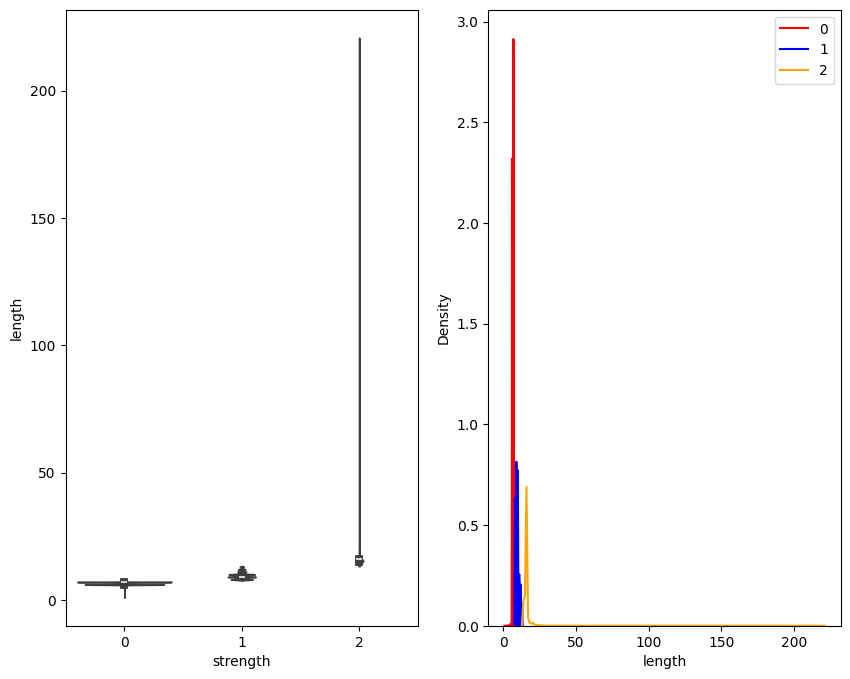

In [39]:
get_dist(data,"length")

->> we have few overlappping region in distribution plot when class is 2 , we have higher value of 'length' than class 1 & class 0

->> it means 'length' is a interesting feature as we have very less overlapping region

->> similarly from violinplot ,we will say on account of less overlappping, this feature 'length' is amazing & useful in determining the strength

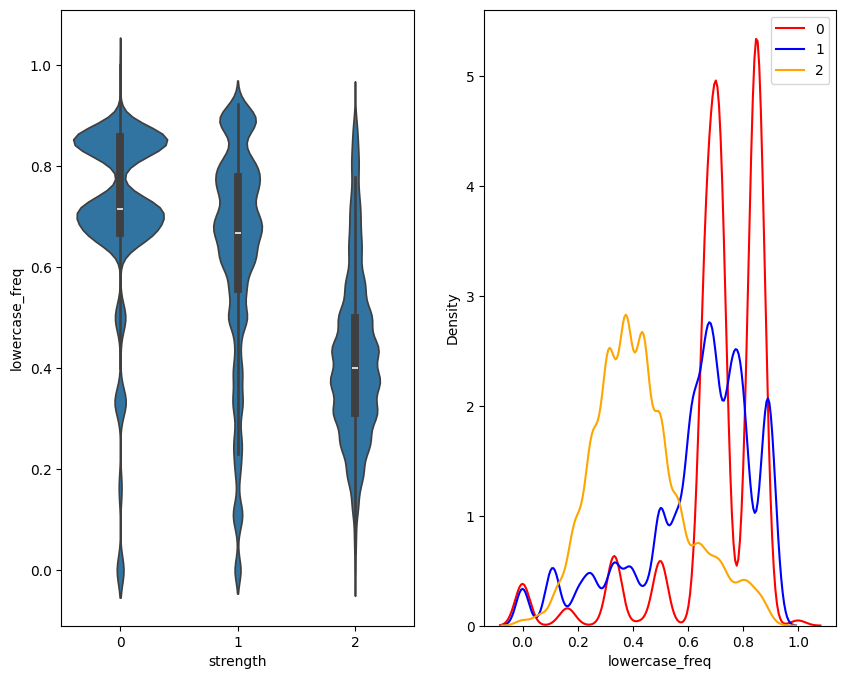

In [40]:
get_dist(data , 'lowercase_freq')

->> we have some kind of overlappping region in distribution plot when class is 2 , we have less value of 'lower_freq' than class 1 & class 0

->> it means 'lower_freq' is a interesting feature upto some extent as have some overlapping region

->> similarly from violinplot ,we will say on account of such overlappping ,when class is 2 we have less value of 'lower_freq' than class 1 & class 0

->> this feature 'lower_freq' is a interesting feature upto some extent in determining the strength

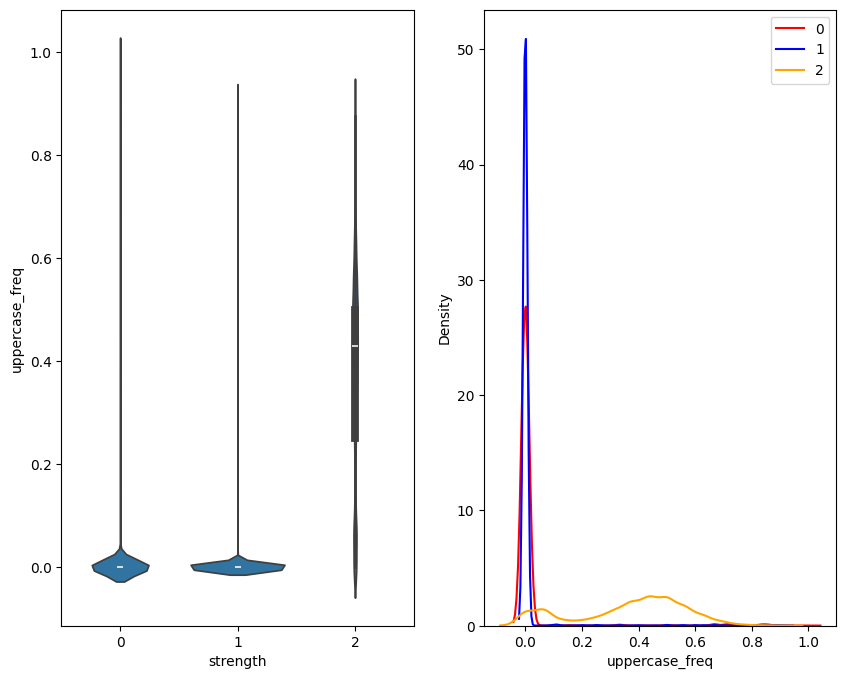

In [41]:
get_dist(data , 'uppercase_freq')

->> we have quite high overlappping region in distribution plot 

->> it means 'upper_freq' is not that much interesting feature as have some overlapping region

->> similarly from violinplot ,we will say on account of such huge overlappping , this feature 'lower_freq' is not a interesting feature in determining the strength

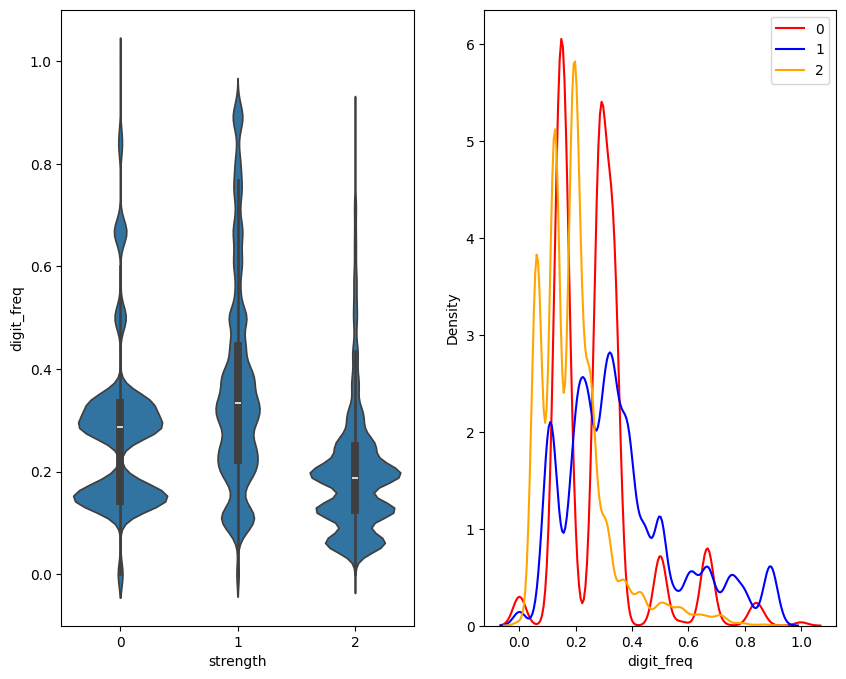

In [42]:
get_dist(data , 'digit_freq')

->> we have quite high overlappping region in distribution plot 

->> it means 'upper_freq' is not that much interesting feature as have some overlapping region

->> similarly from violinplot ,we will say on account of such huge overlappping , this feature 'lower_freq' is not a interesting feature in determining the strength

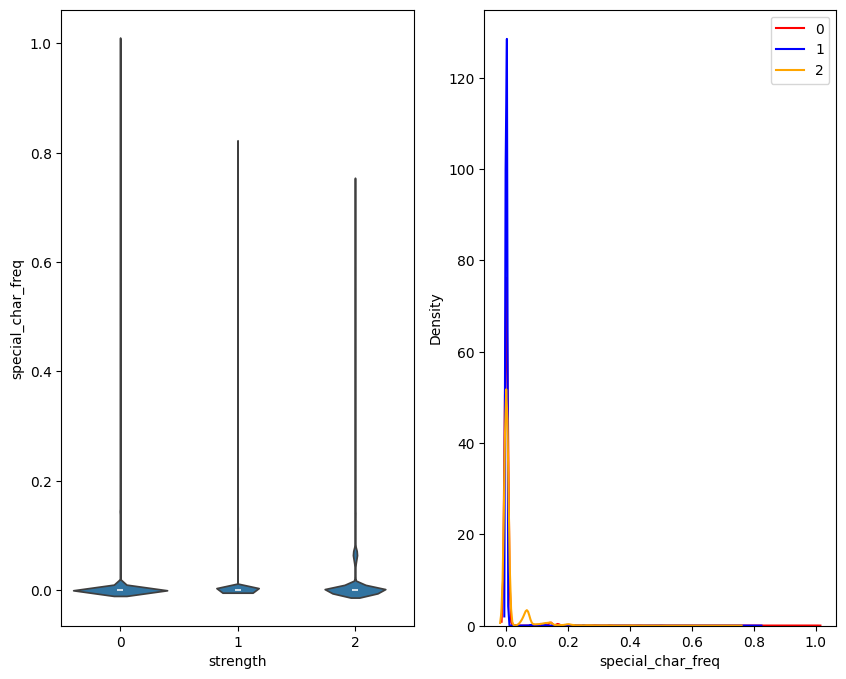

In [43]:
get_dist(data , 'special_char_freq')

->> we have quite high overlappping region in distribution plot 

->> it means 'special_char_freq' is not that much interesting feature as have some overlapping region

->> similarly from violinplot ,we will say on account of such huge overlappping , this feature 'special_char_freq' is not a interesting feature in determining the strength

'''

Key Insight : It ives us idea that length & lowercase freq are important features..


'''

# Applying TF_IDF on data

In [44]:
data.head(4)

password  strength  length  lowercase_freq  uppercase_freq  \
0                zxe870819         1       9           0.333             0.0   
1             xw46454nr23l         1      12           0.417             0.0   
2                soporte13         1       9           0.778             0.0   
3  accounts6000webhost.com         2      23           0.783             0.0   

   digit_freq  special_char_freq  
0       0.667           0.000000  
1       0.583           0.000000  
2       0.222           0.000000  
3       0.174           0.043478

In [45]:
dataframe = data.sample(frac=1) 
# shuffling randomly for robustness of ML moodel

In [46]:
dataframe

password  strength  length  lowercase_freq  uppercase_freq  \
21414  SpKXNejE0NQ6lbzq         2      16           0.438           0.438   
20021         ujmyhn123         1       9           0.667           0.000   
7657   r7JD5jjM0MwSm9Et         2      16           0.375           0.375   
79487        48055683xl         1      10           0.200           0.000   
32007         n96931241         1       9           0.111           0.000   
...                 ...       ...     ...             ...             ...   
96438           bhaal01         0       7           0.714           0.000   
12946      yvoh1h5pad00         1      12           0.667           0.000   
97753  hFz8CzTg5MQPPlcL         2      16           0.375           0.500   
14712         mykaryn91         1       9           0.778           0.000   
83488        mvwkiys807         1      10           0.700           0.000   

       digit_freq  special_char_freq  
21414       0.125                0.0  
20021       0.333                0.0  
7657        0.250                0.0  
79487       0.800                0.0  
32007       0.889                0.0  
...           ...                ...  
96438       0.286                0.0  
12946       0.333                0.0  
97753       0.125                0.0  
14712       0.222                0.0  
83488       0.300                0.0  

[100000 rows x 7 columns]

In [47]:
x = list(dataframe["password"])

In [48]:
# x

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
# importing TF-IDF vectorizer to convert text data into numerical data

->> as password is a series of chars , we have to calculate TF_IDF values of each char 

->> Thats why we have to split our password as-->>

->> kzde5577-->> ['k', 'z', 'd', 'e', '5', '5', '7', '7']


->> then we can compute Tf-Idf value of each character like Tf-IDF value of k , Tf-IDF value of z


In [50]:
vectorizer = TfidfVectorizer(analyzer="char")

In [51]:
X = vectorizer.fit_transform(x)

In [52]:
X.shape

(100000, 99)

->> ie (100000,1) passwords gets represented using (100000, 99)

->> ie each password gets represented using 99 dimensions

In [53]:
dataframe["password"].shape

(100000,)

In [54]:
X

<100000x99 sparse matrix of type '<class 'numpy.float64'>'
	with 842571 stored elements in Compressed Sparse Row format>

In [55]:
X.toarray()
# to get entire matrix of TF-IDF for 100000 passwords

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [56]:
X.toarray()[0]
# TF-IDF scores of Ist row

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.18695879, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.21769234, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.23155751, 0.        ,
       0.        , 0.32362541, 0.        , 0.        , 0.        ,
       0.        , 0.23967599, 0.21389244, 0.19918623, 0.        ,
       0.35514128, 0.        , 0.22805072, 0.5232708 , 0.        ,
       0.1881903 , 0.        , 0.        , 0.        , 0.        ,
       0.26199316, 0.        , 0.24583259, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [57]:
dataframe["password"]

21414    SpKXNejE0NQ6lbzq
20021           ujmyhn123
7657     r7JD5jjM0MwSm9Et
79487          48055683xl
32007           n96931241
               ...       
96438             bhaal01
12946        yvoh1h5pad00
97753    hFz8CzTg5MQPPlcL
14712           mykaryn91
83488          mvwkiys807
Name: password, Length: 100000, dtype: object

In [58]:
len(vectorizer.get_feature_names_out())

99

In [59]:
vectorizer.get_feature_names_out()
# returns feature/char_of_passwords/columns names
# ie these are the various chars to which different TF-IDF values are assigned for 100000 passwords

array(['\x04', '\x06', '\x08', '\x0e', '\x10', '\x11', '\x17', ' ', '!',
       '#', '$', '%', '&', '(', ')', '*', '+', '-', '.', '/', '0', '1',
       '2', '3', '4', '5', '6', '7', '8', '9', ';', '<', '=', '>', '?',
       '@', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f',
       'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's',
       't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '¡', '¨',
       '°', '±', '³', '´', 'µ', '·', 'ß', 'à', 'á', 'ä', 'æ', 'ç', 'é',
       'ê', 'í', 'ñ', 'ó', 'õ', 'ö', '÷', 'ú', 'ü', 'ý', 'þ', '›'],
      dtype=object)

In [60]:
df2 = pd.DataFrame(X.toarray() , columns=vectorizer.get_feature_names_out())

In [61]:
df2

                                 !    #  ...    ñ    ó    õ  \
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
99995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
99996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
99997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
99998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
99999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

         ö    ÷    ú    ü    ý    þ    ›  
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...    ...  ...  ...  ...  ...  ...  ...  
99995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
99996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
99997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
99998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
99999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[100000 rows x 99 columns]

# Applying Machine Learning algorithm

In [62]:
dataframe.columns

Index(['password', 'strength', 'length', 'lowercase_freq', 'uppercase_freq',
       'digit_freq', 'special_char_freq'],
      dtype='object')

In [63]:
df2["length"]=dataframe["length"]
df2["lowercase_freq"]=dataframe["lowercase_freq"]

In [64]:
df2

                                 !    #  ...    õ    ö    ÷  \
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
99995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
99996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
99997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
99998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
99999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

         ú    ü    ý    þ    ›  length  lowercase_freq  
0      0.0  0.0  0.0  0.0  0.0       9           0.333  
1      0.0  0.0  0.0  0.0  0.0      12           0.417  
2      0.0  0.0  0.0  0.0  0.0       9           0.778  
3      0.0  0.0  0.0  0.0  0.0      23           0.783  
4      0.0  0.0  0.0  0.0  0.0       8           0.625  
...    ...  ...  ...  ...  ...     ...             ...  
99995  0.0  0.0  0.0  0.0  0.0      10           0.700  
99996  0.0  0.0  0.0  0.0  0.0      10           0.800  
99997  0.0  0.0  0.0  0.0  0.0       9           0.778  
99998  0.0  0.0  0.0  0.0  0.0       9           0.667  
99999  0.0  0.0  0.0  0.0  0.0      11           0.727  

[100000 rows x 101 columns]

In [65]:
y = dataframe["strength"]

#### split data into train & test
    train---> To learn the relationship within data, 
    test-->  To do predictions, and this testing data will be unseen to my model

In [66]:
X_train, X_test, y_train, y_test = train_test_split(df2, y, test_size=0.20)

In [67]:
X_train.shape

(80000, 101)

In [68]:
y_train.shape

(80000,)

In [69]:
clf = LogisticRegression(multi_class='multinomial')

In [70]:
clf.fit(X_train,y_train)

LogisticRegression(multi_class='multinomial')

In [71]:
y_pred = clf.predict(X_test)

In [72]:
y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [73]:
Counter(y_pred)

Counter({1: 16633, 2: 1773, 0: 1594})

# Doing prediction on sample data

###### as Logistic reg. model'clf' was trained on 101 features [99 from TF-IDF + 2 features from (total_length+lower_case_freq)]
###### hence we need to convert any input(password) into (1,101) so that my model will accept this as Input ..

In [74]:
password = "%@123abcd"

In [75]:
sample_array = np.array([password])

In [76]:
sample_matrix = vectorizer.transform(sample_array)

In [77]:
sample_matrix.toarray()

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.71897928, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.14344586, 0.1659599 , 0.18587581, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.48741481, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.13814351, 0.23158091, 0.21637656,
        0.20807263, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [78]:
sample_matrix.toarray().shape

### right now , array dim. is (1,99) so now we need to make it as : (1,101) so that my model will accept it as input..
### ie we need to add (length_of_password) & (total_lowercase_chars) in passsword

(1, 99)

In [79]:
len(password)

9

In [80]:
[char for char in password if char.islower()]

['a', 'b', 'c', 'd']

In [81]:
len([char for char in password if char.islower()])/len(password)

0.4444444444444444

In [82]:
np.append(sample_matrix.toarray(),(9,0.444)).shape

(101,)

In [83]:
np.append(sample_matrix.toarray(),(9,0.444)).reshape(1,101)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.71897928, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.14344586, 0.1659599 , 0.18587581, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.48741481, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.13814351, 0.23158091, 0.21637656,
        0.20807263, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [84]:
np.append(sample_matrix.toarray() , (9,0.444)).reshape(1,101).shape

(1, 101)

In [85]:
new_matrix = np.append(sample_matrix.toarray() , (9,0.444)).reshape(1,101)

In [86]:
def predict():
    password = input("Enter a password : ")
    sample_array = np.array([password])
    sample_matrix = vectorizer.transform(sample_array)
    
    length_pass = len(password)
    length_normalised_lowercase = len([char for char in password if char.islower()])/len(password)
    
    new_matrix2 = np.append(sample_matrix.toarray() , (length_pass , length_normalised_lowercase)).reshape(1,101)
    result = clf.predict(new_matrix2)
    
    if result == 0 :
        return "Password is weak"
    elif result == 1 :
        return "Password is normal"
    else:
        return "password is strong"

In [87]:
# predict()

In [93]:
def check_password_strength():
    password = values['-PASSWORD-']
    sg.theme('DarkPurple6')
    sample_array = np.array([password])
    sample_matrix = vectorizer.transform(sample_array)
    
    length_pass = len(password)
    length_normalised_lowercase = len([char for char in password if char.islower()]) / len(password)
    
    new_matrix2 = np.append(sample_matrix.toarray(), (length_pass, length_normalised_lowercase)).reshape(1, 101)
    result = clf.predict(new_matrix2)
    
    if result == 0:
        strength = "Password is weak"
    elif result == 1:
        strength = "Password is normal"
    else:
        strength = "Password is strong"
    
    window['-OUTPUT-'].update(strength)

layout = [
    [sg.Text('Enter Password:')],
    [sg.Input(password_char='', key='-PASSWORD-')],
    [sg.Button('Check Strength'), sg.Button('Exit')],
    [sg.Text('', size=(40,1), key='-OUTPUT-')]
]

window = sg.Window('Password Strength Checker', layout)

while True:
    event, values = window.read()
    if event in (sg.WINDOW_CLOSED, 'Exit'):
        break
    if event == 'Check Strength':
        check_password_strength()

window.close()

## Model evaluation :

In [90]:
accuracy_score(y_test , y_pred)

0.8019

In [91]:
confusion_matrix(y_test , y_pred)

array([[  828,  1924,     2],
       [  695, 13727,   288],
       [   71,   982,  1483]], dtype=int64)

In [92]:
print(classification_report(y_test , y_pred))

              precision    recall  f1-score   support

           0       0.52      0.30      0.38      2754
           1       0.83      0.93      0.88     14710
           2       0.84      0.58      0.69      2536

    accuracy                           0.80     20000
   macro avg       0.73      0.61      0.65     20000
weighted avg       0.78      0.80      0.78     20000

